In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices(device_type="GPU")[0], True)

import h5py, os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

from msfm.grid_pipeline import GridPipeline
from msfm.utils import power_spectra, files, scales
from deep_lss.utils import configuration

In [53]:
msfm_conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v10/linear_bias.yaml"
msfm_conf = files.load_config(msfm_conf)

data_vec_pix, patches_pix_dict, _, _ = files.load_pixel_file(msfm_conf)
n_side = msfm_conf["analysis"]["n_side"]
n_pix = msfm_conf["analysis"]["n_pix"]
n_bins = msfm_conf["analysis"]["power_spectra"]["n_bins"]
map_normalization = np.array(msfm_conf["analysis"]["normalization"]["lensing"] + 4 * [1])

dlss_conf = "/global/u2/a/athomsen/y3-deep-lss/configs/v10/combined/dlss_config.yaml"
dlss_conf = configuration.load_deep_lss_config(dlss_conf)

ells = np.arange(3*n_side)

n_cosmos = 1
n_examples = 100

i_example = 0
i_z = 0
# NOTE for the first redshift bin of weak lensing, which is also index 0 of the cross z bins
sigma_noise = dlss_conf["scale_cuts"]["lensing"]["white_noise_sigma"][0]

l_mins = 8 * [30]
def angle_to_ell(angles):
    return list(scales.angle_to_ell(np.array(angles), arcmin=True))
l_maxs = angle_to_ell([22.1, 15.1, 11.2, 9.4] + [65.1, 44.5, 34.1, 28.5])

l_min = l_mins[i_z]
l_max = l_maxs[i_z]

smoothing_fac = scales.gaussian_low_pass_factor_alm(ells, l_max) * scales.gaussian_high_pass_factor_alm(ells, l_min)
bins = power_spectra.get_cl_bins(l_min, l_max, n_bins)

current_binning = lambda cls: binned_statistic(ells, cls, statistic="mean", bins=bins)[0]

24-09-09 00:20:10     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
24-09-09 00:20:10 configuratio INF   Loaded the config 


# cls

In [4]:
# fidu_cls_file = "/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias/cls/fiducial_cls.h5"

# with h5py.File(fidu_cls_file, "r") as f:
#     fidu_cls_raw = f["cls/raw"][:n_examples]
#     fidu_cls_bin = f["cls/binned"][:n_examples]

# print(fidu_cls_raw.shape)
# print(fidu_cls_bin.shape)

In [60]:
grid_cls_file = "/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias/cls/grid_cls.h5"

with h5py.File(grid_cls_file, "r") as f:
    grid_cls_raw = f["cls/raw"][:n_cosmos, :n_examples]
    grid_cls_bin = f["cls/binned"][:n_cosmos, :n_examples]
    
grid_cls_raw = np.squeeze(grid_cls_raw)
grid_cls_bin = np.squeeze(grid_cls_bin)

# normalize
grid_cls_raw /= np.sqrt(map_normalization[i_z])
grid_cls_bin /= np.sqrt(map_normalization[i_z])

print(grid_cls_raw.shape)
print(grid_cls_bin.shape)

(100, 1536, 36)
(100, 64, 36)


In [61]:
noise_cls_file = "/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias/cls/white_noise_0000.h5"

with h5py.File(noise_cls_file, "r") as f:
    noise_cls_raw = f["cls/raw"][:]
    
print(noise_cls_raw.shape)

(240, 1536, 36)


# add noise -> bin

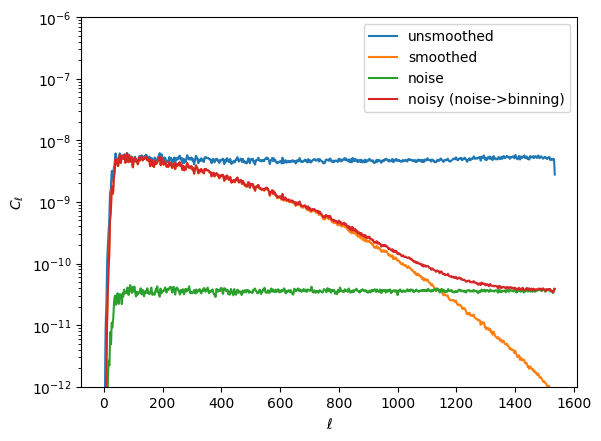

In [62]:
unsmoothed = grid_cls_raw[i_example,:,i_z]
smoothed = unsmoothed * smoothing_fac

f_sky = len(patches_pix_dict["metacal"][0][0])/n_pix
noise = noise_cls_raw[i_example,:,i_z] * sigma_noise**2 * f_sky

noisy = smoothed + noise

fig, ax = plt.subplots()

ax.plot(ells, unsmoothed, label="unsmoothed")
ax.plot(ells, smoothed, label="smoothed")
ax.plot(ells, noise, label="noise")
ax.plot(ells, noisy, label="noisy (noise->binning)")

ax.set(yscale="log", xlabel=r"$\ell$", ylabel=r"$C_\ell$", ylim=(1e-12, 1e-6))
ax.legend()

In [29]:
noisy_binned_1 = current_binning(noisy)

# noisy_binned = power_spectra.bin_cls(
#     noisy,
#     l_min,
#     l_max,
#     n_bins,
#     with_cross=True,
#     fixed_binning=False,
# )

# bin -> add noise

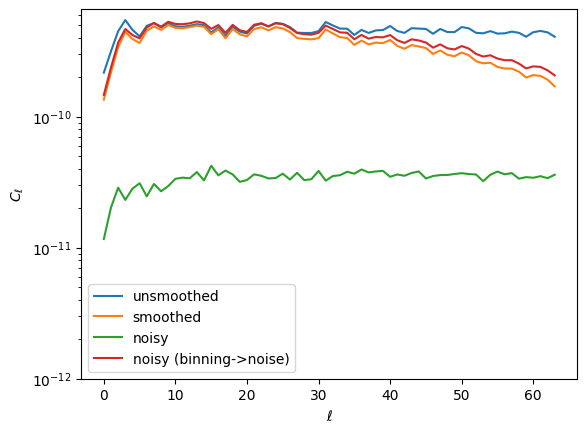

In [37]:
unsmoothed_binned = current_binning(unsmoothed)
smoothed_binned = unsmoothed_binned * current_binning(smoothing_fac)
noise_binned = current_binning(noise)
noisy_binned_2 = noise_binned + smoothed_binned

fig, ax = plt.subplots()

ax.plot(unsmoothed_binned, label="unsmoothed")
ax.plot(smoothed_binned, label="smoothed")
ax.plot(noise_binned, label="noisy")
ax.plot(noisy_binned_2, label="noisy (binning->noise)")

ax.set(yscale="log", xlabel=r"$\ell$", ylabel=r"$C_\ell$", ylim=(1e-12, None))
ax.legend()

# comparison

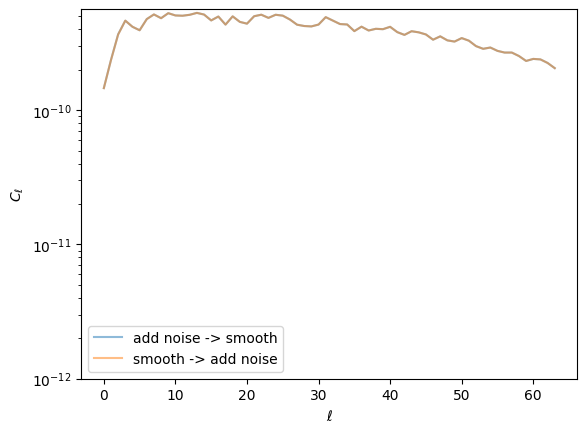

In [38]:
fig, ax = plt.subplots()

ax.plot(noisy_binned_1, label="add noise -> smooth", alpha=0.5)
ax.plot(noisy_binned_2, label="smooth -> add noise", alpha=0.5)

ax.set(yscale="log", xlabel=r"$\ell$", ylabel=r"$C_\ell$", ylim=(1e-12, None))
ax.legend()

# .tfrecords

In [63]:
tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias/tfrecords/grid/DESy3_grid_dmb_0000.tfrecord"

grid_pipe = GridPipeline(
    conf=msfm_conf,
    with_lensing=True,
    with_clustering=True,
    with_padding=True,
    apply_norm=True,
    return_maps=True,
    return_cls=True,
)

grid_dset = grid_pipe.get_dset(
    tfr_pattern=tfr_pattern,
    local_batch_size=1,
    n_readers=1,
    n_prefetch=0,
    is_eval=True,
)

# i = 0
# for dv, cl, cosmo, index in grid_dset:


24-09-09 00:23:09     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
24-09-09 00:23:09     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
24-09-09 00:23:10 grid_pipelin INF   n_workers is not set, using tf.data.AUTOTUNE. This might produce unexpected RAM usage. 
24-09-09 00:23:10 grid_pipelin INF   drop_remainder is not set, using drop_remainder = False 
24-09-09 00:23:10 grid_pipelin INF   Including noise_indices = [0] 
24-09-09 00:23:10 grid_pipelin INF   Interleaving with n_readers = 1 
dict_keys(['cosmo', 'i_sobol', 'i_example', 'kg', 'dg', 'cl'])
24-09-09 00:23:10 grid_pipelin INF   Batching into 1 elements locally 
24-09-09 00:23:10 grid_pipelin WAR   Tracing _augmentations 
24-09-09 00:23:10 grid_pipelin INF   Running on the data_vectors.keys() = dict_keys(['cosmo', 'i_sobol', 'i_example', 'kg', 'dg', 'cl', 

(1, 460800, 8)
(1, 1536, 36)


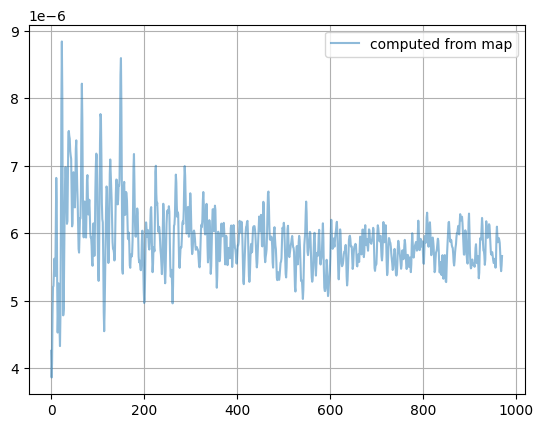

In [65]:
i_z = 0
i_b = 0
for i, (dv, cl, cosmo, index) in enumerate(grid_dset.take(1)):
    print(dv.shape)
    print(cl.shape)
    
    dv_map = np.zeros(n_pix)
    dv_map[data_vec_pix] = dv[i_b,:,i_z]
    dv_map = hp.reorder(dv_map, n2r=True)
    
    dv_cl = hp.anafast(dv_map)
    
    l_min, l_max = 30, 1000
    fig, ax = plt.subplots()
    ax.plot(dv_cl[l_min:l_max], label="computed from map", alpha=0.5)
    ax.grid(True)
    ax.legend()
    # ax.set(yscale="log", title=f"example {i}", ylim=(1e-12, 1e-9))


# build a new dataset

In [3]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices(device_type="GPU")[0], True)

import h5py, os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from tqdm import tqdm

from msi.utils import input_output, dataset, preprocessing
from msfm.grid_pipeline import GridPipeline
from msfm.utils import power_spectra, files, scales
from deep_lss.utils import configuration

In [3]:
base_dir = "/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias"
conf = files.load_config("/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v10/linear_bias.yaml")

In [ ]:


cls_dict = input_output.load_human_summaries(
    base_dir, "cls", file_label=None, return_raw_cls=False, return_fiducial=False, return_grid=True
)

In [7]:
base_dir = "/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias"

cls_dict = input_output.load_human_summaries(
    base_dir, "cls", file_label=None, return_raw_cls=False, return_fiducial=True, return_grid=True
)

print(np.sum(np.isnan(cls_dict["fiducial/cls/binned"])))
print(np.sum(np.isnan(cls_dict["grid/cls/binned"])))

24-09-10 00:53:26 input_output INF   Array shapes: 
24-09-10 00:53:26 input_output INF   fiducial/i_example = (39920,) 
24-09-10 00:53:26 input_output INF   fiducial/i_noise   = (39920,) 
24-09-10 00:53:26 input_output INF   fiducial/cls/binned = (39920, 64, 36) 
24-09-10 00:53:26 input_output INF   fiducial/cls/bin_edges = (65, 36) 
24-09-10 00:53:26 input_output INF   grid/cosmo         = (2500, 400, 12) 
24-09-10 00:53:26 input_output INF   grid/i_example     = (2500, 400) 
24-09-10 00:53:26 input_output INF   grid/i_noise       = (2500, 400) 
24-09-10 00:53:26 input_output INF   grid/i_sobol       = (2500, 400) 
24-09-10 00:53:32 input_output INF   grid/cls/binned    = (2500, 400, 64, 36) 
24-09-10 00:53:32 input_output INF   grid/cls/bin_edges = (2500, 65, 36) 
24-09-10 00:53:32 input_output INF   Done loading the summaries after 0:00:05.96 
0
36000000


In [8]:
cls_dict["grid/cls/binned"].size

2304000000

In [9]:
2304000000/36000000

64.0

In [23]:
cls_dict.keys()

dict_keys(['grid/cosmo', 'grid/i_example', 'grid/i_noise', 'grid/i_sobol', 'grid/cls/binned', 'grid/cls/bin_edges'])

In [24]:
cls_dict["grid/cls/binned"].shape

(2500, 400, 64, 36)

In [31]:
cls_dict["grid/cls/binned"][0,0,:,3]

array([            nan,  6.77844927e-22,  3.52638386e-18,  4.63890828e-16,
        6.48440652e-15,  1.72857388e-13,  1.69765504e-12,  1.54319821e-11,
        6.86812829e-11,  1.09469628e-10,  2.54897131e-10,  2.86250995e-10,
        2.83384399e-10,  2.12729556e-10,  2.66852290e-10,  1.26806454e-10,
        1.43036777e-10,  1.07593913e-10,  7.50453519e-11,  1.42904882e-10,
        1.31321273e-10,  1.08808448e-10,  7.84779949e-11,  1.10853195e-10,
        9.19945856e-11,  6.68513717e-11,  1.03102610e-10,  9.35744607e-11,
        3.25788112e-11,  2.13287721e-11,  5.08445161e-11,  4.66095461e-11,
        3.55979170e-11,  4.31479644e-11,  2.92292614e-11,  3.51981118e-11,
        2.43036528e-11,  2.40183897e-11,  1.17555948e-11,  1.87707436e-11,
        3.47855807e-11,  2.12397738e-11,  1.65545216e-11,  5.96443207e-12,
        1.33801468e-11,  9.90927999e-12,  8.10769247e-12,  6.71484699e-12,
        7.12410903e-12,  4.01093004e-12,  7.05620415e-12,  5.97970588e-12,
        2.79321011e-12,  

In [5]:
# fidu_summs, grid_summs, grid_cosmos, grid_i_sobols, file_dict, scaler, pca = preprocessing.get_reshaped_human_summaries(
#     base_dir,
#     "cls",
#     # file
#     file_label=None,
#     # configuration
#     conf=None,
#     params=None,
#     concat_example_dim=False,
#     do_plot=False,
#     # selection
#     with_lensing=True,
#     with_clustering=True,
#     with_cross_z=True,
#     with_cross_probe=True,
#     # additional preprocessing
#     apply_log=False,
#     standardize=False,
#     pca_components=None,
# )

In [6]:
l_mins = 8 * [30]
def angle_to_ell(angles):
    return list(scales.angle_to_ell(np.array(angles), arcmin=True))
l_maxs = angle_to_ell([22.1, 15.1, 11.2, 9.4] + [65.1, 44.5, 34.1, 28.5])
n_bins = 65

fidu_summs, grid_summs, grid_cosmos, grid_i_sobols, file_dict, scaler, pca = preprocessing.get_reshaped_human_summaries(
    base_dir,
    "cls",
    # file
    file_label=None,
    # configuration
    conf=conf,
    concat_example_dim=False,
    do_plot=False,
    # selection
    with_lensing=True,
    with_clustering=True,
    with_cross_z=True,
    with_cross_probe=True,
    # power spectra
    l_mins=l_mins,
    l_maxs=l_maxs,
    n_bins=n_bins,
    # additional preprocessing
    apply_log=False,
    standardize=False,
    pca_components=None,
)

24-09-09 03:07:01 preprocessin INF   Loading the pre-binned Cls 
24-09-09 03:07:01 input_output INF   Array shapes: 
24-09-09 03:07:01 input_output INF   fiducial/i_example = (39920,) 
24-09-09 03:07:01 input_output INF   fiducial/i_noise   = (39920,) 
24-09-09 03:07:02 input_output INF   fiducial/cls/binned = (39920, 64, 36) 
24-09-09 03:07:02 input_output INF   fiducial/cls/bin_edges = (65, 36) 
24-09-09 03:07:02 input_output INF   grid/cosmo         = (2500, 400, 12) 
24-09-09 03:07:02 input_output INF   grid/i_example     = (2500, 400) 
24-09-09 03:07:02 input_output INF   grid/i_noise       = (2500, 400) 
24-09-09 03:07:02 input_output INF   grid/i_sobol       = (2500, 400) 
24-09-09 03:07:14 input_output INF   grid/cls/binned    = (2500, 400, 64, 36) 
24-09-09 03:07:14 input_output INF   grid/cls/bin_edges = (2500, 65, 36) 
24-09-09 03:07:14 input_output INF   Done loading the summaries after 0:00:13.31 
24-09-09 03:07:14 preprocessin INF   Applying scale cuts to the pre-binned C

In [5]:
noise_cls = input_output.load_cl_white_noise(base_dir)

In [6]:
noise_cls.shape

(50000, 64, 36)

In [5]:
noise_cls = input_output.load_cl_white_noise(base_dir)
noise_cls = np.concatenate([noise_cls[..., i] for i in range(noise_cls.shape[-1])], axis=-1)


In [6]:
noise_cls.shape

(1000, 2304)

In [10]:
noise_cls = input_output.load_cl_white_noise(base_dir)
noise_cls = np.concatenate([noise_cls[..., i] for i in range(noise_cls.shape[-1])], axis=-1)
noise_cls = np.nan_to_num(noise_cls)

dset_noise = tf.data.Dataset.from_tensor_slices(noise_cls)
dset_noise = dset_noise.cache().repeat().shuffle(128)

In [18]:
noise_cls.shape

(50000, 2304)

In [21]:
steps = 100_000
for x in tqdm(dset_noise.take(steps), total=steps):
    pass

100%|██████████| 100000/100000 [00:04<00:00, 20606.10it/s]


In [10]:
import h5py

In [27]:
grid_file = "/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias/cls/debug/grid_cls.h5"

with h5py.File(grid_file, "r") as f:
    print(f.keys())
    
    examples = f["cls/binned"][:]

print(examples.shape)
print(np.sum(np.isnan(examples)))

<KeysViewHDF5 ['cls', 'cosmo', 'i_example', 'i_noise', 'i_sobol']>
(10, 400, 32, 36)
0


In [28]:
fidu_file = "/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias/cls/debug/fiducial_cls.h5"

with h5py.File(fidu_file, "r") as f:
    print(f.keys())
    
    examples = f["cls/binned"][:]

print(examples.shape)
print(np.sum(np.isnan(examples)))

<KeysViewHDF5 ['cls', 'i_example', 'i_noise']>
(100, 32, 36)
0
